# Loading the data

In [1]:
import pandas as pd

data = pd.read_csv('Codeacademy_Webscrapper_20210107154307.csv')
data.head()

,Unnamed: 0,Topic Title,Category,Tags,Leading Comment,Other Comments,Likes,Views
0,0,[How to] Format code in posts,Getting Started,[],Codecademy Discuss posts are parsed with Markd...,[],21,13.9k
1,1,Guide: A list of how-to’s for giving and recei...,Getting Started,[],Technical guides will teach you how to use the...,[],0,0
2,2,Guide: Learn about our community forums,Getting Started,[],Take a moment and read through each of these b...,[],0,0
3,3,[How-to] Create a topic that everyone will read,Getting Started,[],A great topic is one that provides potential h...,[],0,0
4,4,[Learn More] How the forum is organized,Getting Started,[],"With Codecademy Community forums, conversation...",[],0,0


In [2]:
data.columns

Index(['Unnamed: 0', 'Topic Title', 'Category', 'Tags', 'Leading Comment',
       'Other Comments', 'Likes', 'Views'],
      dtype='object')

In [3]:
data.drop(columns= ['Unnamed: 0', 'Likes', 'Views'], inplace=True)
data

,Topic Title,Category,Tags,Leading Comment,Other Comments
0,[How to] Format code in posts,Getting Started,[],Codecademy Discuss posts are parsed with Markd...,[]
1,Guide: A list of how-to’s for giving and recei...,Getting Started,[],Technical guides will teach you how to use the...,[]
2,Guide: Learn about our community forums,Getting Started,[],Take a moment and read through each of these b...,[]
3,[How-to] Create a topic that everyone will read,Getting Started,[],A great topic is one that provides potential h...,[]
4,[Learn More] How the forum is organized,Getting Started,[],"With Codecademy Community forums, conversation...",[]
...,...,...,...,...,...
5459,Why does it ask me not to use compute_bill?,FAQ,['Python FAQ'],Question\nWhy does it ask me not to use comput...,['Question\nWhy does it ask me not to use comp...
5460,FAQ: Learn Python - Battleship - A Real Win,FAQ,['Python FAQ'],\nCommunity FAQs on Codecademy Python Exercise...,['\nCommunity FAQs on Codecademy Python Exerci...
5461,How should I indent the code to create my_tria...,FAQ,['Python FAQ'],Question\nHow should I indent the code to crea...,[]
5462,FAQ: Learn Python - Battleship - Not Again!,FAQ,['Python FAQ'],\nCommunity FAQs on Codecademy Python Exercise...,['\nCommunity FAQs on Codecademy Python Exerci...


# Strategy 1

* Lower case all the words

* Replaced by space these [/(){}[]\'\“\”\’|@,;]

* Removed these [^0-9a-z #+_]


# Explore the data

In [4]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline

In [5]:
df = data.copy()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5464 entries, 0 to 5463
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Topic Title      5464 non-null   object
 1   Category         5464 non-null   object
 2   Tags             5464 non-null   object
 3   Leading Comment  5464 non-null   object
 4   Other Comments   5464 non-null   object
dtypes: object(5)
memory usage: 213.6+ KB


In [7]:
df['post'] = df['Topic Title'] + ' ' + df['Tags'] + ' ' + df['Leading Comment'] + ' ' + df['Other Comments']

df['post'].head()

0    [How to] Format code in posts [] Codecademy Di...
1    Guide: A list of how-to’s for giving and recei...
2    Guide: Learn about our community forums [] Tak...
3    [How-to] Create a topic that everyone will rea...
4    [Learn More] How the forum is organized [] Wit...
Name: post, dtype: object

In [8]:
print(df['post'].apply(lambda x: len(x.split(' '))).sum())

13091057


In [9]:
df['Category'].unique()

array(['Getting Started', 'Get Help', 'Community', 'Projects', 'FAQ'],
      dtype=object)

Text(0, 0.5, 'no of posts')

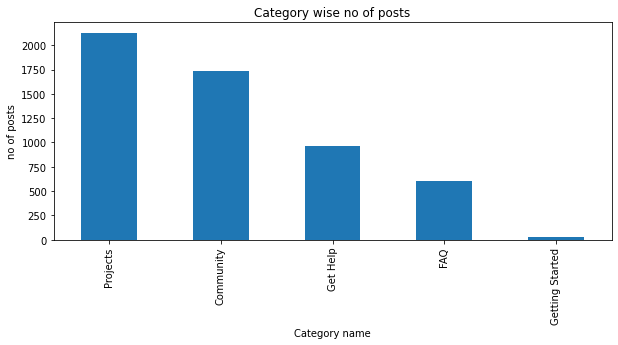

In [10]:
my_categories = ['Getting Started', 'Get Help',
       'Community', 'Projects', 'FAQ']
plt.figure(figsize=(10,4))
df.Category.value_counts().plot(kind='bar');
# Add title and axis names
plt.title('Category wise no of posts')
plt.xlabel('Category name')
plt.ylabel('no of posts')

####  Data is imbalanced. Need to work on this.

In [12]:
def print_plot(index):
    example = df[df.index == index][['post', 'Category']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Category:', example[1])
print_plot(1)

Guide: A list of how-to’s for giving and receiving code-help [] Technical guides will teach you how to use the forums. These guides cover how the forums are organized, how to use the features of the forums, and quick tips for posting!

[Learn More] How the forum is organized 41
[How to] Format code in posts 17
[How-to] Find and read topics to learn more 12
[How-to] Search for previous answers 6
[How-to] Reply to a post 4
[How-to] Create a topic that everyone will read 15
[How-to] See who’s online right now 8
[How to] Manage your preferences 3
 []
Category: Getting Started


# Text Pre-processing

In [13]:
test_df = df.copy()

In [14]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\'\“\”\’\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
#STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    #text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    #text = ''.join(word for word in text if word not in punct)  # remove punctuation
    #text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
test_df['post'] = test_df['post'].apply(clean_text)

In [15]:
def test_print_plot(index):
    example = test_df[test_df.index == index][['post', 'Category']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Category:', example[1])
test_print_plot(1)

guide: a list of how-to s for giving and receiving code-help    technical guides will teach you how to use the forums. these guides cover how the forums are organized  how to use the features of the forums  and quick tips for posting!

 learn more  how the forum is organized 41
 how to  format code in posts 17
 how-to  find and read topics to learn more 12
 how-to  search for previous answers 6
 how-to  reply to a post 4
 how-to  create a topic that everyone will read 15
 how-to  see who s online right now 8
 how to  manage your preferences 3
   
Category: Getting Started


In [16]:
test_df['post'].apply(lambda x: len(x.split(' '))).sum()

15332524

In [18]:
15332524-13091057

2241467

#### I lost 2241467 info.

# Modeling the data

In [19]:
X = test_df.post
y = test_df.Category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [20]:
X_train.head()

4998    what else can i make with what i ve learned so...
1623     video  how to get a job as a developer   tips...
5161    how does this update the text on every change?...
4320    visualizing the orion constellation    hi  the...
2678    reference error:undefined    hi all \ni ve bee...
Name: post, dtype: object

In [21]:
y_train.head()

4998          FAQ
1623    Community
5161          FAQ
4320     Projects
2678    Community
Name: Category, dtype: object

# Naive Bayes Classifier for Multinomial Models

### CountVectorizer + TF-IDFTransformer + MultinomialNB

In [22]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)


from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
res1311 = accuracy_score(y_pred, y_test)
print(classification_report(y_test, y_pred,target_names=my_categories))

accuracy 0.6195121951219512
                 precision    recall  f1-score   support

Getting Started       0.67      0.89      0.76       534
       Get Help       0.00      0.00      0.00       177
      Community       1.00      0.01      0.01       318
       Projects       0.00      0.00      0.00         6
            FAQ       0.58      0.89      0.70       605

       accuracy                           0.62      1640
      macro avg       0.45      0.36      0.30      1640
   weighted avg       0.63      0.62      0.51      1640



c:\users\hp\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Linear Support Vector Machine

### CountVectorizer + TF-IDFTransformer + SGDClassifier

In [23]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
res1321 = accuracy_score(y_pred, y_test)
print(classification_report(y_test, y_pred,target_names=my_categories))

accuracy 0.7341463414634146
                 precision    recall  f1-score   support

Getting Started       0.77      0.87      0.81       534
       Get Help       0.73      0.86      0.79       177
      Community       0.90      0.11      0.20       318
       Projects       0.00      0.00      0.00         6
            FAQ       0.70      0.91      0.80       605

       accuracy                           0.73      1640
      macro avg       0.62      0.55      0.52      1640
   weighted avg       0.76      0.73      0.68      1640



# Logistic Regression

### CountVectorizer + TF-IDFTransformer + Logistic Regression


In [24]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

y_pred = logreg.predict (X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
res1331 = accuracy_score(y_pred, y_test)
print(classification_report(y_test, y_pred,target_names=my_categories))

c:\users\hp\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy 0.7634146341463415
                 precision    recall  f1-score   support

Getting Started       0.79      0.83      0.81       534
       Get Help       0.85      0.82      0.84       177
      Community       0.60      0.48      0.54       318
       Projects       0.00      0.00      0.00         6
            FAQ       0.78      0.84      0.81       605

       accuracy                           0.76      1640
      macro avg       0.61      0.60      0.60      1640
   weighted avg       0.75      0.76      0.76      1640



c:\users\hp\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Decision Tree

### CountVectorizer + TF-IDFTransformer + DecisionTreeClassifier

In [25]:
from sklearn.tree import DecisionTreeClassifier

dtree = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', DecisionTreeClassifier(random_state=0)),
               ])
dtree.fit(X_train, y_train)

y_pred = dtree.predict (X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
res1341 = accuracy_score(y_pred, y_test)
print(classification_report(y_test, y_pred,target_names=my_categories))

accuracy 0.7292682926829268
                 precision    recall  f1-score   support

Getting Started       0.76      0.77      0.76       534
       Get Help       0.97      0.95      0.96       177
      Community       0.48      0.41      0.44       318
       Projects       0.00      0.00      0.00         6
            FAQ       0.75      0.81      0.78       605

       accuracy                           0.73      1640
      macro avg       0.59      0.59      0.59      1640
   weighted avg       0.72      0.73      0.72      1640



# Results

### Results of the previously trained models

In [26]:
import pandas as pd

results = pd.DataFrame({'Model': ['Naive Bayes MultinomialNB', 'Linear SVM', 'Logistic Regression', 'Decision Tree'],
                         'Accuracy': [res1311, res1321, res1331, res1341]})
results.set_index('Model')
results.sort_values(by='Accuracy')

,Model,Accuracy
0,Naive Bayes MultinomialNB,0.619512
3,Decision Tree,0.729268
1,Linear SVM,0.734146
2,Logistic Regression,0.763415


# Cross Validation with linear SVM

In [27]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
cv_res_sgd = cross_val_score(sgd, X_train, y_train, cv=10)
mean_cv_res_sgd = np.mean(cv_res_sgd)

In [28]:
print(mean_cv_res_sgd)

0.7583742293549136


# Strategy 2

* Remove stop words (+ what was done in Strategy 1)

In [30]:
test_df2 = test_df.copy()

In [31]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\'\“\”\’\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    #text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    #text = ''.join(word for word in text if word not in punct)  # remove punctuation
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
test_df2['post'] = test_df2['post'].apply(clean_text)

In [32]:
def test_print_plot(index):
    example = test_df2[test_df2.index == index][['post', 'Category']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Category:', example[1])
test_print_plot(1)

guide: list how-to giving receiving code-help technical guides teach use forums. guides cover forums organized use features forums quick tips posting! learn forum organized 41 format code posts 17 how-to find read topics learn 12 how-to search previous answers 6 how-to reply post 4 how-to create topic everyone read 15 how-to see online right 8 manage preferences 3
Category: Getting Started


# Modeling the data

In [33]:
X = test_df2.post
y = test_df2.Category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [34]:
X_train.head()

4998    else make learned far? python faq question els...
1623    video get job developer tips resources want ge...
5161    update text every change? react.js faq questio...
4320    visualizing orion constellation hi results fir...
2678    reference error:undefined hi stuck error day l...
Name: post, dtype: object

In [35]:
y_train.head()

4998          FAQ
1623    Community
5161          FAQ
4320     Projects
2678    Community
Name: Category, dtype: object

# Naive Bayes Classifier for Multinomial Models

### CountVectorizer + TF-IDFTransformer + MultinomialNB

In [36]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)


from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
res2311 = accuracy_score(y_pred, y_test)
print(classification_report(y_test, y_pred,target_names=my_categories))

accuracy 0.6268292682926829
                 precision    recall  f1-score   support

Getting Started       0.70      0.87      0.78       534
       Get Help       1.00      0.01      0.02       177
      Community       1.00      0.01      0.02       318
       Projects       0.00      0.00      0.00         6
            FAQ       0.57      0.92      0.70       605

       accuracy                           0.63      1640
      macro avg       0.66      0.36      0.31      1640
   weighted avg       0.74      0.63      0.52      1640



c:\users\hp\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Linear Support Vector Machine

### CountVectorizer + TF-IDFTransformer + SGDClassifier

In [37]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
res2321 = accuracy_score(y_pred, y_test)
print(classification_report(y_test, y_pred,target_names=my_categories))

accuracy 0.7414634146341463
                 precision    recall  f1-score   support

Getting Started       0.77      0.89      0.82       534
       Get Help       0.75      0.83      0.79       177
      Community       0.80      0.13      0.22       318
       Projects       0.00      0.00      0.00         6
            FAQ       0.71      0.92      0.80       605

       accuracy                           0.74      1640
      macro avg       0.61      0.55      0.53      1640
   weighted avg       0.75      0.74      0.69      1640



# Logistic Regression

### CountVectorizer + TF-IDFTransformer + Logistic Regression

In [38]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

y_pred = logreg.predict (X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
res2331 = accuracy_score(y_pred, y_test)
print(classification_report(y_test, y_pred,target_names=my_categories))

c:\users\hp\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy 0.7579268292682927
                 precision    recall  f1-score   support

Getting Started       0.79      0.83      0.81       534
       Get Help       0.81      0.79      0.80       177
      Community       0.60      0.46      0.52       318
       Projects       0.50      0.33      0.40         6
            FAQ       0.78      0.85      0.81       605

       accuracy                           0.76      1640
      macro avg       0.70      0.65      0.67      1640
   weighted avg       0.75      0.76      0.75      1640



# Decision Tree

### CountVectorizer + TF-IDFTransformer + DecisionTreeClassifier

In [39]:
from sklearn.tree import DecisionTreeClassifier

dtree = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', DecisionTreeClassifier(random_state=0)),
               ])
dtree.fit(X_train, y_train)

y_pred = dtree.predict (X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
res2341 = accuracy_score(y_pred, y_test)
print(classification_report(y_test, y_pred,target_names=my_categories))

accuracy 0.7225609756097561
                 precision    recall  f1-score   support

Getting Started       0.75      0.75      0.75       534
       Get Help       0.98      0.95      0.96       177
      Community       0.46      0.39      0.42       318
       Projects       0.11      0.17      0.13         6
            FAQ       0.75      0.81      0.78       605

       accuracy                           0.72      1640
      macro avg       0.61      0.61      0.61      1640
   weighted avg       0.72      0.72      0.72      1640



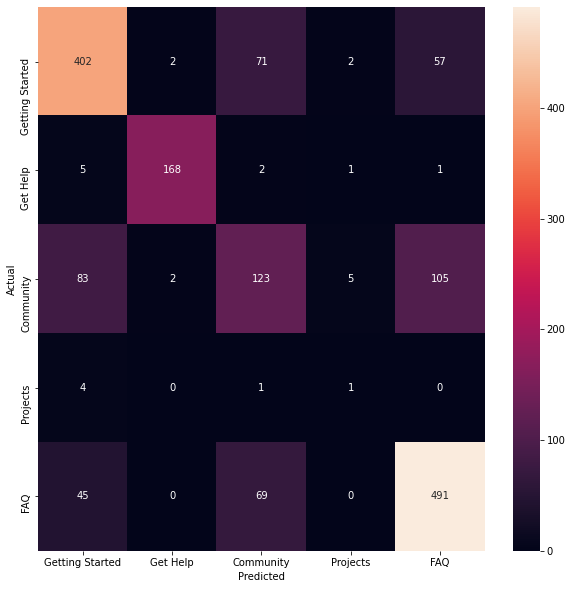

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=my_categories, yticklabels=my_categories)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Results

### Results of the previously trained models

In [41]:
import pandas as pd

results = pd.DataFrame({'Model': ['Naive Bayes MultinomialNB', 'Linear SVM', 'Logistic Regression', 'Decision Tree'],
                         'Accuracy': [res2311, res2321, res2331, res2341]})
results.set_index('Model')
results.sort_values(by='Accuracy')

,Model,Accuracy
0,Naive Bayes MultinomialNB,0.626829
3,Decision Tree,0.722561
1,Linear SVM,0.741463
2,Logistic Regression,0.757927


#### So after removing the stop words the accuracy of the maximum accurate machine learning model decreases by 0.006

# Cross Validation with linear SVM

In [42]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
cv_res_sgd2 = cross_val_score(sgd, X_train, y_train, cv=10)
mean_cv_res_sgd2 = np.mean(cv_res_sgd2)

In [43]:
print(mean_cv_res_sgd2)

0.7588943720694982


#  Strategy 3

* text.replace(r'\n', ' ') & Remove digits and words containing digits (+ what was done in Strategy 2)

In [44]:
test_df3 = test_df2.copy()

In [45]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\'\“\”\’\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
DIGITS_RE=re.compile('\w*\d\w*')

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = text.replace(r'\n', ' ')
    #text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    #text = ''.join(word for word in text if word not in punct)  # remove punctuation
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    text = DIGITS_RE.sub('', text)
    return text
    
test_df3['post'] = test_df3['post'].apply(clean_text)

In [46]:
def test_print_plot(index):
    example = test_df3[test_df3.index == index][['post', 'Category']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Category:', example[1])
test_print_plot(1)

guide: list how-to giving receiving code-help technical guides teach use forums. guides cover forums organized use features forums quick tips posting! learn forum organized  format code posts  how-to find read topics learn  how-to search previous answers  how-to reply post  how-to create topic everyone read  how-to see online right  manage preferences 
Category: Getting Started


# Cross Validation with linear SVM

In [47]:
X = test_df3.post
y = test_df3.Category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [48]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
cv_res_sgd3 = cross_val_score(sgd, X_train, y_train, cv=10)
mean_cv_res_sgd3 = np.mean(cv_res_sgd3)

In [49]:
print(mean_cv_res_sgd3)

0.7536662884639044


# Random Forest

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

rf = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(n_estimators=500, max_depth=500, random_state=0)),
               ])

cv_res_rf = cross_val_score(rf, X_train, y_train, cv=10)
mean_cv_res_rf = np.mean(cv_res_rf)

In [51]:
print(mean_cv_res_rf)#max_depth = 10, n_estimators=300

0.7905403742840348


In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

rf = Pipeline([('vect', TfidfVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(n_estimators=200, max_depth=100, random_state=0)),
               ])

cv_res_rf_tfidf = cross_val_score(rf, X_train, y_train, cv=10)
mean_cv_res_rf_tfidf = np.mean(cv_res_rf_tfidf)

In [58]:
mean_cv_res_rf_tfidf# max_depth = 500, n_estimators=500

0.7811238090030483

In [63]:
# from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

sgd = Pipeline([('vect', TfidfVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=100, tol=None)),
               ])
cv_res_sgd_tfidf = cross_val_score(sgd, X_train, y_train, cv=10)
mean_cv_res_sgd_tfidf = np.mean(cv_res_sgd_tfidf)

In [64]:
mean_cv_res_sgd_tfidf #10 in max_iter

0.7426797260536138

# XGBoost

In [69]:
pip install xgboost

You should consider upgrading via the 'c:\users\hp\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [70]:
import xgboost as xgb

xgb = Pipeline(steps=[('vect', TfidfVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('xgboost', xgb.XGBClassifier(objective='multi:softmax'))])

cv_res_xgb_tfidf = cross_val_score(xgb, X_train, y_train, cv=10)
mean_cv_res_xgb_tfidf = np.mean(cv_res_xgb_tfidf)

c:\users\hp\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:12:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:12:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:13:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:13:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

In [72]:
mean_cv_res_xgb_tfidf

0.8551255587604063

In [ ]:
# xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

In [77]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
res_xgb = accuracy_score(y_pred, y_test)
print(classification_report(y_test, y_pred,target_names=my_categories))

accuracy 0.8384146341463414
                 precision    recall  f1-score   support

Getting Started       0.85      0.90      0.88       534
       Get Help       0.98      0.98      0.98       177
      Community       0.77      0.50      0.60       318
       Projects       0.00      0.00      0.00         6
            FAQ       0.81      0.93      0.87       605

       accuracy                           0.84      1640
      macro avg       0.68      0.66      0.67      1640
   weighted avg       0.83      0.84      0.83      1640



c:\users\hp\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### So I got  max accuracy of 83.85 after training xgboost model

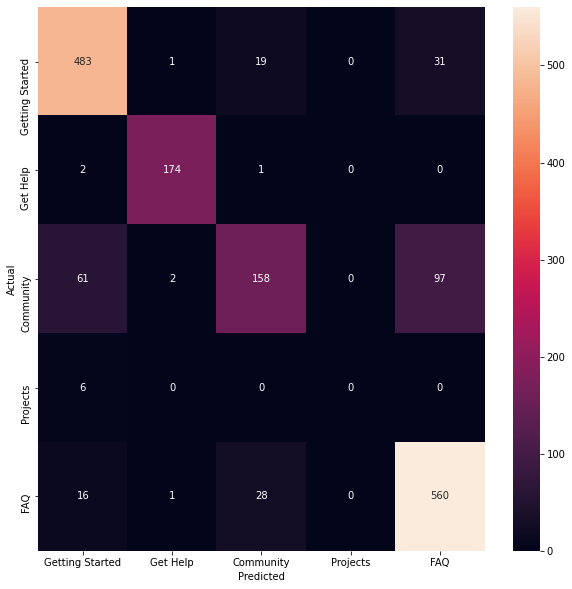

In [76]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=my_categories, yticklabels=my_categories)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


## We can see that:

* **Some posts (16 posts) from FAQ got misclassified as Getting started.**
* **Some posts (28 posts) from FAQ got misclassified as Community.**
* **61 posts from Community got misclassified as Getting started.**
* **97 posts from Community got misclassified as FAQ.**


In [78]:
import lightgbm as lgbm

tfidf_vec = TfidfVectorizer(dtype=np.float32, sublinear_tf=True, use_idf=True, smooth_idf=True)
X_data_tfidf = tfidf_vec.fit_transform(test_df3['post'])
X_train_tfidf = tfidf_vec.transform(X_train)
X_test_tfidf = tfidf_vec.transform(X_test)

clf_LGBM = lgbm.LGBMClassifier(objective='multiclass', verbose=-1, learning_rate=0.5, max_depth=20, num_leaves=50, n_estimators=120, max_bin=2000,)
clf_LGBM.fit(X_train_tfidf, y_train, verbose=-1)
predicted_LGBM = clf_LGBM.predict(X_test_tfidf)

In [79]:
cv_res_lgbm_tfidf = cross_val_score(clf_LGBM, X_train_tfidf, y_train, cv=10)
mean_cv_res_lgbm_tfidf = np.mean(cv_res_lgbm_tfidf)

In [80]:
mean_cv_res_lgbm_tfidf

0.5513957048924856

In [81]:
print('accuracy %s' % accuracy_score(predicted_LGBM, y_test))
res_lgbm = accuracy_score(predicted_LGBM, y_test)
print(classification_report(y_test, predicted_LGBM,target_names=my_categories))

accuracy 0.4945121951219512
                 precision    recall  f1-score   support

Getting Started       0.42      0.57      0.48       534
       Get Help       0.53      0.76      0.62       177
      Community       0.27      0.11      0.16       318
       Projects       0.00      0.00      0.00         6
            FAQ       0.64      0.56      0.60       605

       accuracy                           0.49      1640
      macro avg       0.37      0.40      0.37      1640
   weighted avg       0.48      0.49      0.47      1640



###  after using tf-idf accuracy has decresed a lot.

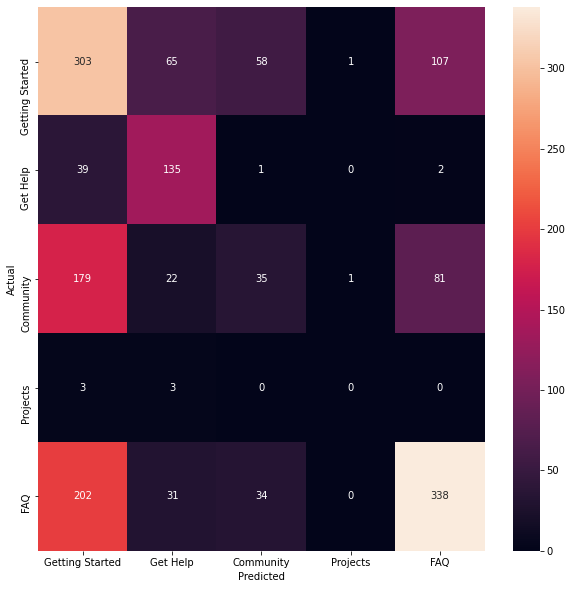

In [82]:
conf_mat = confusion_matrix(y_test, predicted_LGBM)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=my_categories, yticklabels=my_categories)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [83]:
data = pd.read_csv('Codeacademy_Webscrapper_20210107154307.csv')

In [84]:
STOPWORDS = set(stopwords.words('english'))
STOPWORDSv2 = [word.upper() for word in STOPWORDS]

In [85]:
STOPWORDSv2

['YOURS',
 'WOULDN',
 'HERE',
 'WASN',
 "WOULDN'T",
 'NOR',
 "WASN'T",
 'EACH',
 'BELOW',
 'ANY',
 'ONLY',
 'THAN',
 'MORE',
 'DOESN',
 'O',
 'OFF',
 'S',
 'AFTER',
 'WHERE',
 'WHY',
 'SAME',
 'AS',
 'HADN',
 'ITSELF',
 'MA',
 'HAVEN',
 'OR',
 "SHE'S",
 'WHAT',
 'CAN',
 'SO',
 'IT',
 'FOR',
 'THEIR',
 'BOTH',
 'COULDN',
 'THEY',
 'TOO',
 'UP',
 'HIMSELF',
 'DOWN',
 'ON',
 "DON'T",
 'AGAIN',
 "COULDN'T",
 'ME',
 'AREN',
 'MUSTN',
 'HASN',
 "SHOULDN'T",
 'OURS',
 'THEM',
 'HER',
 'THERE',
 'RE',
 'SHAN',
 'INTO',
 "HAVEN'T",
 "SHAN'T",
 'ONCE',
 'MY',
 'AN',
 "IT'S",
 "WON'T",
 'IF',
 'OF',
 'WE',
 'HAS',
 'TO',
 'BEFORE',
 'HIM',
 "YOU'RE",
 'FURTHER',
 "SHOULD'VE",
 'JUST',
 'MOST',
 'DURING',
 'YOURSELF',
 'I',
 'AGAINST',
 'ABOVE',
 'WHICH',
 'THEMSELVES',
 "MIGHTN'T",
 'WITH',
 'SHOULD',
 'THE',
 'BEING',
 'Y',
 'VERY',
 'IS',
 'HE',
 'AM',
 'T',
 'ITS',
 'UNTIL',
 "YOU'LL",
 'THAT',
 "YOU'VE",
 'MYSELF',
 'DOING',
 'OVER',
 "ISN'T",
 'OWN',
 'THESE',
 'BECAUSE',
 'WON',
 'WERE',
 '

In [86]:
def clean_data(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = ' '.join(word for word in text.split() if word not in STOPWORDSv2) # delete stopwors from text
    return text
    
data['Leading Comment'] = data['Leading Comment'].apply(clean_data)

c:\users\hp\appdata\local\programs\python\python38\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "https://www.codecademy.com/paths/web-development/tracks/styling-a-website/modules/learn-css-selectors-visual-rules/lessons/css-setup-selectors/exercises/intro-to-css" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [87]:
data['Leading Comment'].head()

0    Codecademy Discuss posts are parsed with Markd...
1    Technical guides will teach you how to use the...
2    Take a moment and read through each of these b...
3    great topic is one that provides potential hel...
4    With Codecademy Community forums, conversation...
Name: Leading Comment, dtype: object

In [88]:
upcase_words = {}
regex = r"([A-Z]{3})"

for i, row in zip(range(500), data['Leading Comment'][:500]):
    row = data['Leading Comment'].str.findall(regex)[i]
    if len(row) != 0:
        upcase_words[i] = row

In [89]:
df_upword = pd.DataFrame(upcase_words.items(), columns=['Original Index', 'Upper Case Words'])

In [90]:
df_upword.head()

,Original Index,Upper Case Words
0,0,[HTM]
1,3,[URL]
2,11,"[HTM, HTM]"
3,14,"[HTM, BBC]"
4,15,"[FAQ, NOT, TOS]"


In [91]:
df_upword['Number of UpCase Words'] =  df_upword['Upper Case Words'].apply(lambda x: len(x))

In [92]:
df_upword.head()

,Original Index,Upper Case Words,Number of UpCase Words
0,0,[HTM],1
1,3,[URL],1
2,11,"[HTM, HTM]",2
3,14,"[HTM, BBC]",2
4,15,"[FAQ, NOT, TOS]",3


In [93]:
df_upword['Number of UpCase Words'].values.max()

77

In [94]:
df_upword['Number of UpCase Words'][df_upword['Number of UpCase Words'].values == 77]

33    77
Name: Number of UpCase Words, dtype: int64

In [95]:
df_upword['Number of UpCase Words'][33]

77

In [96]:
df_upword['Upper Case Words'][33]

['CRE',
 'ATE',
 'TAB',
 'DEC',
 'IMA',
 'NUL',
 'DEF',
 'AUL',
 'PRI',
 'MAR',
 'KEY',
 'VAR',
 'CHA',
 'NUL',
 'DEC',
 'IMA',
 'NUL',
 'DEF',
 'AUL',
 'DEC',
 'IMA',
 'NUL',
 'UNI',
 'QUE',
 'CRE',
 'ATE',
 'TAB',
 'VAR',
 'CHA',
 'UNI',
 'QUE',
 'NUL',
 'PRI',
 'MAR',
 'KEY',
 'VAR',
 'CHA',
 'NUL',
 'VAR',
 'CHA',
 'NUL',
 'VAR',
 'CHA',
 'VAR',
 'CHA',
 'DAT',
 'NUL',
 'VAR',
 'CHA',
 'NUL',
 'DEC',
 'IMA',
 'NUL',
 'DEC',
 'IMA',
 'DEC',
 'IMA',
 'NUL',
 'DEF',
 'AUL',
 'DEC',
 'IMA',
 'NUL',
 'DEF',
 'AUL',
 'FOR',
 'EIG',
 'KEY',
 'REF',
 'ERE',
 'NCE',
 'FOR',
 'EIG',
 'KEY',
 'REF',
 'ERE',
 'NCE']

In [97]:
abb = {}
for word in df_upword['Upper Case Words'][33]:
    if word in abb.keys():
        abb[word] += 1
    else:
        abb[word] = 1

In [98]:
abb

{'CRE': 2,
 'ATE': 2,
 'TAB': 2,
 'DEC': 7,
 'IMA': 7,
 'NUL': 12,
 'DEF': 4,
 'AUL': 4,
 'PRI': 2,
 'MAR': 2,
 'KEY': 4,
 'VAR': 7,
 'CHA': 7,
 'UNI': 2,
 'QUE': 2,
 'DAT': 1,
 'FOR': 2,
 'EIG': 2,
 'REF': 2,
 'ERE': 2,
 'NCE': 2}

# The ones that looks legilible to me are: 
'CRE',
 'ATE',
 'TAB',
 **'DEC'**,
 **'IMA'**,
 **'NUL'**,
 'DEF',
 'AUL',
 'PRI',
 'MAR',
 'KEY',
 **'VAR',
 'CHA',**
 'UNI',
 'QUE',
 'DAT',
 'FOR',
 'EIG',
 'REF',
 'ERE',
 'NCE'}
**The ones that looks leg**